# Third Point

Use transfer learning based on a pre-trained network in two manners.

In [1]:
import cv2 as cv2
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras import optimizers, initializers
from keras.preprocessing import image
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten,Dropout, MaxPooling2D, AveragePooling2D
from keras.utils import to_categorical, plot_model
from keras.callbacks import EarlyStopping, History
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import import_ipynb
import dataSetUtility as dsu
import plottingUtility as pltu

importing Jupyter notebook from dataSetUtility.ipynb
importing Jupyter notebook from plottingUtility.ipynb


Read all images and create a Training Data

In [2]:
#path to the directories
pathTrain=r'C:\Users\adria\Desktop\CVPR\ImageSet\train'
pathTest=r'C:\Users\adria\Desktop\CVPR\ImageSet\test'

labels = [os.path.basename(i) for i in glob.glob(pathTrain + '/*', recursive=True)]
numberOfClasses = len(labels)
print("Class number: ", numberOfClasses)
print("Class names: ", labels)

Class number:  15
Class names:  ['Bedroom', 'Coast', 'Forest', 'Highway', 'Industrial', 'InsideCity', 'Kitchen', 'LivingRoom', 'Mountain', 'Office', 'OpenCountry', 'Store', 'Street', 'Suburb', 'TallBuilding']


To use images on VGG they need to have size (224, 224)

In [3]:
xTrain, yTrain = dsu.loadImages(pathTrain, labels, dimension=224)
xTest, yTest = dsu.loadImages(pathTest, labels, dimension=224)

create a list of images for train and test set

In [4]:
trainImagesList = []
testImagesList = []
for label in labels:
    sTrain = pathTrain+'/'+label+'/{}'
    sTest = pathTest+'/'+label+'/{}'
    tempTrain = [sTrain.format(i) for i in os.listdir(pathTrain+'/'+label+'/')]
    tempTest = [sTest.format(i) for i in os.listdir(pathTest+'/'+label+'/')]
    trainImagesList = trainImagesList + tempTrain
    testImagesList = testImagesList + tempTest

prepocessing images using keras libraries for VGG

In [5]:
trainImages = []
for img in trainImagesList:
    tmp = image.load_img(img, target_size=(224,224))
    tmp = image.img_to_array(tmp)
    trainImages.append(tmp)


trainImages=np.array(trainImages)
trainImg=preprocess_input(trainImages)
trainLabelsDummy=to_categorical(yTrain,15)

In [6]:
testImages = []
for img in testImagesList:
    tmp = image.load_img(img, target_size=(224,224))
    tmp = image.img_to_array(tmp)
    testImages.append(tmp)

testImages=np.array(testImages)
testImg=preprocess_input(testImages)
testLabelsDummy=to_categorical(yTest,15)

We build the VGG16 model

In [7]:
adam = optimizers.Adam()
vgg = VGG16(weights='imagenet', include_top=True)
model = Sequential()
#freeze all layers except the last one

for layer in vgg.layers[:-1]:
    layer.trainable = False
    model.add(layer)
    
model.add(Dense(15, activation='softmax'))

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [8]:
earlyStopping = EarlyStopping(min_delta=0.00,patience = 5)
history = model.fit(trainImg,trainLabelsDummy,batch_size=64,
                    epochs=10,validation_split=0.15,shuffle=True,
                    callbacks=[earlyStopping])

Epoch 1/10
20/20 [==============================] - 150s 8s/step - loss: 1.9002 - accuracy: 0.4581 - val_loss: 13.7742 - val_accuracy: 0.1111
Epoch 2/10
20/20 [==============================] - 151s 8s/step - loss: 0.2766 - accuracy: 0.8986 - val_loss: 15.1802 - val_accuracy: 0.0978
Epoch 3/10
20/20 [==============================] - 152s 8s/step - loss: 0.1378 - accuracy: 0.9560 - val_loss: 15.6132 - val_accuracy: 0.0978
Epoch 4/10
20/20 [==============================] - 148s 7s/step - loss: 0.0985 - accuracy: 0.9745 - val_loss: 14.9936 - val_accuracy: 0.1067
Epoch 5/10
20/20 [==============================] - 152s 8s/step - loss: 0.0605 - accuracy: 0.9901 - val_loss: 15.4338 - val_accuracy: 0.1022
Epoch 6/10
20/20 [==============================] - 148s 7s/step - loss: 0.0452 - accuracy: 0.9967 - val_loss: 15.1075 - val_accuracy: 0.1067


In [9]:
ev = model.evaluate(testImg, testLabelsDummy)

94/94 [==============================] - 352s 4s/step - loss: 2.6001 - accuracy: 0.7605


In [10]:
prediction = model.predict(testImg)

ValueError: Classification metrics can't handle a mix of unknown and multiclass targets

In [12]:
yPred = dsu.predictClass(prediction)
cm=confusion_matrix(yTest, yPred)

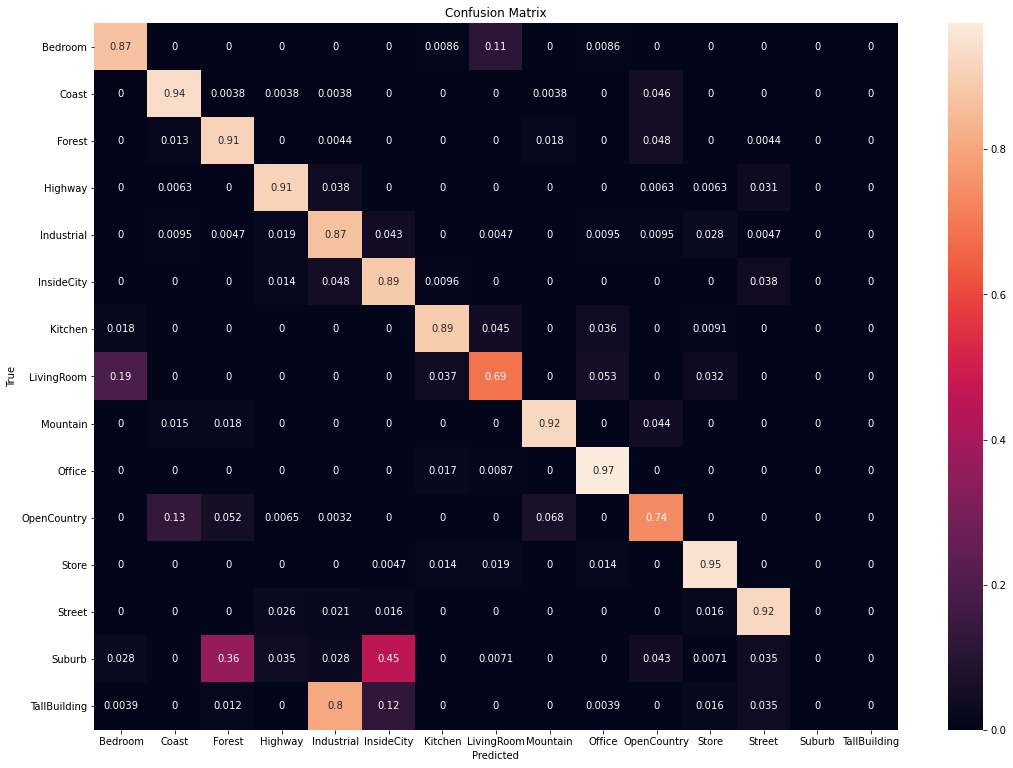

In [14]:
pltu.plotConfusionMatrix(cm, labels, "confusion_matrix_1", "images_point_three/")

In [ ]:
pltu.validationLoss(history, "images_point_three", "validation_loss_1")